__Tutorial 1: The Leaky Integrate-and-Fire (LIF) Neuron Model__
***
In this tutorial, we aim to implement the Linear Integrate-and-Fire neuron model. This reduced-neuron model is an abstraction that describes how neurons spike by integrating external currents passed along their dendrites. The LIF model is described by:
$$
C_m \frac{dV}{dt} = -g_L(V - E_L) + I
$$
where $C_m$ is the membrance capacitance, $V$ is the membrane potential, which is a function of time, $g_L$ is the leak conductance (inverse of the leak resistance), $E_L$ is the resting potential of the neuron, and $I$ is the external input current, which is also a function of time. Note that this current only considers the Na and K ion channels, which are responsible for generating the action potential. Dividing both sides by $g_L$, we obtain:
$$
\tau_m \frac{dV}{dt} = (V - E_L) + \frac{I}{g_L}
$$
where $\tau_m = \frac{C_m}{g_L}$ is the membrane time constant.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

# Plotting Functions

def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])


def plot_GWN(pars, I_GWN):
  """
  Args:
    pars  : parameter dictionary
    I_GWN : Gaussian white noise input

  Returns:
    figure of the gaussian white noise input
  """

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
  """
  Args:
    isi1 : vector with inter-spike intervals
    isi2 : vector with inter-spike intervals
    cv1  : coefficient of variation for isi1
    cv2  : coefficient of variation for isi2

  Returns:
    figure with two histograms, isi1, isi2

  """
  plt.figure(figsize=(11, 4))
  my_bins = np.linspace(10, 30, 20)
  plt.subplot(121)
  plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

  plt.subplot(122)
  plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
  plt.tight_layout()
  plt.show()

To implement the model, we follow the following algorithm: <br>
If $V(t) = V_th$, then $V(t + \Delta) = E_L$ <br>
where $V_th$ is a threshold defined for the neuron to spike, and $\Delta$ is the absolute refractory period (the time after spiking until the neuron is reset to the resting potential).

Default Parameteres: {'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0, 'g_L': 10.0, 'V_init': -75.0, 'E_L': -75.0, 'tref': 2.0, 'T': 400.0, 'dt': 0.1, 'range_t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.997e+02, 3.998e+02,
       3.999e+02])}


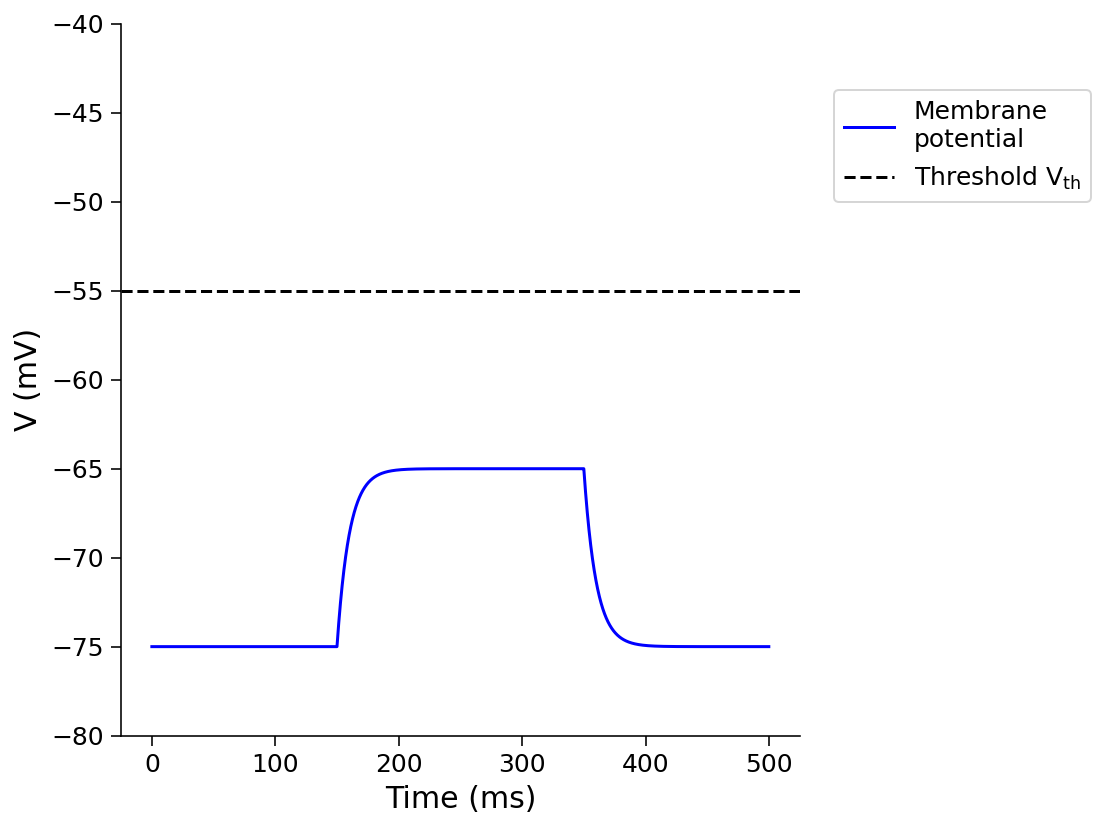

In [6]:
def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
print("Default Parameteres:", pars)


def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage
  v = np.zeros(Lt)
  v[0] = V_init

  # Set current time course
  Iinj = Iinj * np.ones(Lt)

  # If current pulse, set beginning and end to 0
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0

  # Loop over time
  rec_spikes = []  # record spike times
  tr = 0.  # the count for refractory duration

  for it in range(Lt - 1):

    if tr > 0:  # check if in refractory period
      v[it] = V_reset  # set voltage to reset
      tr = tr - 1 # reduce running counter of refractory period

    elif v[it] >= V_th:  # if voltage over threshold
      rec_spikes.append(it)  # record spike event
      v[it] = V_reset  # reset voltage
      tr = tref / dt  # set refractory time

    # Calculate the increment of the membrane potential
    dv = (dt / tau_m) * ((-(v[it] - E_L)) + (Iinj[it] / g_L))

    # Update the membrane potential
    v[it + 1] = v[it] + dv

  # Get spike times in ms
  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


# Get parameters
pars = default_pars(T=500)

# Simulate LIF model
v, sp = run_LIF(pars, Iinj=100, stop=True)

# Visualize
plot_volt_trace(pars, v, sp)

We now explore the dynamics of the model in response to a direct current (DC). We observe that if the amplitude of the current is large enough to cause the neuron to reach its threshold, the interspike interval is regular and constant.

In [7]:
my_layout.width = '450px'
@widgets.interact(
    I_dc=widgets.FloatSlider(50., min=0., max=300., step=10.,
                               layout=my_layout),
    tau_m=widgets.FloatSlider(10., min=2., max=20., step=2.,
                                layout=my_layout)
)

def diff_DC(I_dc=200., tau_m=10.):
  pars = default_pars(T=100.)
  pars['tau_m'] = tau_m
  v, sp = run_LIF(pars, Iinj=I_dc)
  plot_volt_trace(pars, v, sp)
  plt.show()

interactive(children=(FloatSlider(value=50.0, description='I_dc', layout=Layout(width='450px'), max=300.0, ste…

We now consider the case of noise added to the input current. The noise distribution will be Gaussian with a mean equal to the amplitude of the current (Note: if the variance is 0, this is equivalent to the DC current). As the variance of the noise distribution increases, the interspike interval becomes more irregular.

In [8]:
# Helper Function to define Gaussian White Noise (GWN) for the input current
def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn

my_layout.width = '450px'
@widgets.interact(
    mu_gwn=widgets.FloatSlider(200., min=100., max=300., step=5.,
                               layout=my_layout),
    sig_gwn=widgets.FloatSlider(2.5, min=0., max=5., step=.5,
                                layout=my_layout)
)


def diff_GWN_to_LIF(mu_gwn, sig_gwn):
  pars = default_pars(T=100.)
  I_GWN = my_GWN(pars, mu=mu_gwn, sig=sig_gwn)
  v, sp = run_LIF(pars, Iinj=I_GWN)
  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=200.0, description='mu_gwn', layout=Layout(width='450px'), max=300.0, …

Below, we plot the input-output transfer function of the neuron, or F-I curve (define F-I curve from Video 2)

In [9]:
my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(3.0, min=0., max=6., step=0.5,
                                layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
  pars = default_pars(T=1000.)
  I_mean = np.arange(100., 400., 10.)
  spk_count = np.zeros(len(I_mean))
  spk_count_dc = np.zeros(len(I_mean))

  for idx in range(len(I_mean)):
      I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn, myseed=2020)
      v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
      v_dc, rec_sp_dc = run_LIF(pars, Iinj=I_mean[idx])
      spk_count[idx] = len(rec_spikes)
      spk_count_dc[idx] = len(rec_sp_dc)

  # Plot the F-I curve i.e. Output firing rate as a function of input mean.
  plt.figure()
  plt.plot(I_mean, spk_count, 'k',
           label=r'$\sigma_{\mathrm{GWN}}=%.2f$' % sig_gwn)
  plt.plot(I_mean, spk_count_dc, 'k--', alpha=0.5, lw=4, dashes=(2, 2),
           label='DC input')
  plt.ylabel('Spike count')
  plt.xlabel('Average injected current (pA)')
  plt.legend(loc='best')
  plt.show()

interactive(children=(FloatSlider(value=3.0, description='sig_gwn', layout=Layout(width='450px'), max=6.0, ste…

In the plot above, we that as the variance of the noise distribution increases, the average amplitude of the injected current becomes smoother and more linear. This shows that increasing the variance generally increases the number of spikes observed to be more than in the case of a DC current.

The regularity of spikes can be quantified as the coefficient of varation ($CV$) of the interspike interval ($ISI$):
$$
CV_{ISI} = \frac{std(ISI)}{mean(ISI)}
$$

From the functional form above, we can see that with increased variance, the ISIs become more irregular. However, the effect of the variance on the irregularity of the ISIs is less prominent for a high mean (large amplitude of input current). Below, we implement a function to compute $CV_{ISI}$ for various noise distributions.

In [10]:
def isi_cv_LIF(spike_times):
  """
  Calculates the interspike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train

  Args:
    spike_times : (n, ) vector with the spike times (ndarray)

  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)

  """
  if len(spike_times) >= 2:
    # Compute isi
    isi = np.diff(spike_times)
    # Compute cv
    cv = np.std(isi) / np.mean(isi)
  else:
    isi = np.nan
    cv = np.nan

  return isi, cv

my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(0.0, min=0., max=10.,
                                step=0.5, layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
  pars = default_pars(T=1000.)
  I_mean = np.arange(100., 400., 20)
  spk_count = np.zeros(len(I_mean))
  cv_isi = np.empty(len(I_mean))

  for idx in range(len(I_mean)):
    I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn)
    v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
    spk_count[idx] = len(rec_spikes)
    if len(rec_spikes) > 3:
      isi = np.diff(rec_spikes)
      cv_isi[idx] = np.std(isi) / np.mean(isi)

  # Plot the F-I curve i.e. Output firing rate as a function of input mean.
  plt.figure()
  plt.plot(I_mean[spk_count > 5], cv_isi[spk_count > 5], 'bo', alpha=0.5)
  plt.xlabel('Average injected current (pA)')
  plt.ylabel(r'Spike irregularity ($\mathrm{CV}_\mathrm{ISI}$)')
  plt.ylim(-0.1, 1.5)
  plt.grid(True)
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='sig_gwn', layout=Layout(width='450px'), max=10.0, st…

In [ ]:
# Implement more biologically accurate neuron models discussed in bonus material here